## Sources: 
General theory:
- <https://machinelearningmastery.com/review-of-architectural-innovations-for-convolutional-neural-networks-for-image-classification/>
- <https://towardsdatascience.com/from-alexnet-to-nasnet-a-brief-history-and-introduction-of-convolutional-neural-networks-cf63bf3320e1>
- <https://ichi.pro/pl/architektury-cnn-lenet-alexnet-vgg-googlenet-resnet-i-inne-112564940344821>


Models:
- AlexNet: <https://medium.com/analytics-vidhya/multi-class-image-classification-using-alexnet-deep-learning-network-implemented-in-keras-api-c9ae7bc4c05f>
- VGGNet: <https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/>
- ResNet: <https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33>
- DenseNet: <https://towardsdatascience.com/review-densenet-image-classification-b6631a8ef803>
- NasNet: <https://www.kaggle.com/CVxTz/cnn-starter-nasnet-mobile-0-9709-lb>


## Libraries

In [2]:
# base
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from datetime import datetime

# file management
import os
import cv2

# data preprosessing
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# data evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from numpy import interp

# network layers
from keras.models import Sequential,Model,load_model
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,Input,ZeroPadding2D,Add,Activation,BatchNormalization,GlobalAveragePooling2D,AveragePooling2D,GlobalMaxPooling2D,MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.initializers import glorot_uniform

# pretrained models
from keras.applications.densenet import DenseNet121
from keras.applications.nasnet import NASNetMobile
from keras.applications.resnet50 import ResNet50

# plots
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## 1. Loading data

In [2]:
# Defining number of categories and image resolution
label_categories = 10
img_size = 224
batch_size = 32

The images are stored in the data folder with seperate catalogs representing each of the breeds. In total, there are 120 breeds but we will limit to only 10 as the training speed is really slow. 

In order to extract the data, the functions below map all folders, extract the images, resize then to 224x224 pixels (standard size for image recognition) and assign a label based on the folder name. The labels have a specific form (e.g. 'n02108915-French_bulldog'), so we will also need to remove the prefix. 

Additionally, in order to improve the model performance, we will increase the number of images by rotating and fliping them. This way the models will become more robust and learn to recognize the breeds from different positions. 

In [3]:
# 1.1 FUNCTIONS FOR DATA PREPARATION

# Function for navigating the data folder
def data_prep(data_dir, img_resolution, n_categories = 0):
    
    # Data directory
    parent_folder = os.path.expanduser(data_dir)
    
    # Get names of folders(classes)
    class_names = os.listdir(parent_folder) 
    if n_categories>1:
        class_names = random.sample(class_names, n_categories)
        
    # prepare data
    X_images, Y_labels = training_data(parent_folder, class_names, img_resolution)
    return X_images, Y_labels, class_names

# Function for extracting images from folder
def training_data(parent_folder, class_names, img_resolution):
    
    # Empty output
    X_images = []
    Y_labels = []
    
    # Iterate through each folder
    for image_folder in class_names:
        
        # Extracting labels and specifying path
        label = label_assignment(image_folder)
        data_dir = parent_folder+"/"+image_folder
        
        # Iterate through images in folder
        for image_name in tqdm(os.listdir(data_dir)):
            
            # setting path to image
            path = os.path.join(data_dir, image_name)
            
            # image conversion           
            img = cv2.imread(path) # read image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # set color
            img_array = Image.fromarray(img, 'RGB') # Convert to RGB format
            resized_img = img_array.resize((img_resolution, img_resolution)) # resize image to match network input

            # appending the original image to output
            X_images.append(np.array(resized_img))
            Y_labels.append(str(label)) 
    
            # Generating more data in order to increase model effectiveness:
        
            # 1) Flipping images by the x axis
            resized_img_x = resized_img.transpose(Image.FLIP_LEFT_RIGHT)
            X_images.append(np.array(resized_img_x))
            Y_labels.append(str(label)) 
            # 2) Flipping images by the y axis
            resized_img_y = resized_img.transpose(Image.FLIP_TOP_BOTTOM)
            X_images.append(np.array(resized_img_y))
            Y_labels.append(str(label)) 
            # 3) Flipping images by both axis
            resized_img_x_y = resized_img.transpose(Image.FLIP_LEFT_RIGHT).transpose(Image.FLIP_TOP_BOTTOM)
            X_images.append(np.array(resized_img_x_y))
            Y_labels.append(str(label)) 
            
            # 4) Flipping images by 90 degrees
            resized_img_90 = resized_img.transpose(Image.ROTATE_90)
            X_images.append(np.array(resized_img_90))
            Y_labels.append(str(label))     
            # 5) Flipping images by 90 degrees and x axis
            resized_img_90_x = resized_img_90.transpose(Image.FLIP_LEFT_RIGHT)
            X_images.append(np.array(resized_img_90_x))
            Y_labels.append(str(label))    
            # 6) Flipping images by 90 degrees and y axis
            resized_img_90_y = resized_img_90.transpose(Image.FLIP_TOP_BOTTOM)
            X_images.append(np.array(resized_img_90_y))
            Y_labels.append(str(label))               
            # 7) Flipping images by 90 degrees and both axis
            resized_img_90_x_y = resized_img_90.transpose(Image.FLIP_LEFT_RIGHT).transpose(Image.FLIP_TOP_BOTTOM)
            X_images.append(np.array(resized_img_90_x_y))
            Y_labels.append(str(label))        
            
            # 8) Flipping images by 270 degrees
            resized_img_270 = resized_img.transpose(Image.ROTATE_270)
            X_images.append(np.array(resized_img_270))
            Y_labels.append(str(label))     
            # 9) Flipping images by 270 degrees and x axis
            resized_img_270_x = resized_img_270.transpose(Image.FLIP_LEFT_RIGHT)
            X_images.append(np.array(resized_img_270_x))
            Y_labels.append(str(label))    
            # 10) Flipping images by 270 degrees and y axis
            resized_img_270_y = resized_img_270.transpose(Image.FLIP_TOP_BOTTOM)
            X_images.append(np.array(resized_img_270_y))
            Y_labels.append(str(label))               
            # 11) Flipping images by 90 degrees and both axis
            resized_img_270_x_y = resized_img_270.transpose(Image.FLIP_LEFT_RIGHT).transpose(Image.FLIP_TOP_BOTTOM)
            X_images.append(np.array(resized_img_270_x_y))
            Y_labels.append(str(label))  
            
            
    return X_images, Y_labels
        
# Function for correcting labels
def label_assignment(input):
    name = str(input)
    label = '_'.join(name.split("-")[1:]).title()
    return label

In [4]:
# 1.2 EXTRACTING IMAGES

# Empty output
random_seed = 42

# Loading data
images, labels, class_names = data_prep(data_dir = 'data/images/', img_resolution=img_size, n_categories = label_categories)
print("No. of images loaded: ", len(images),
      "\nNo. of labels loaded: ", len(labels),
      "\nSelected breeds: ", class_names)

100%|████████████████████████████████████████████████████████████████████████████████| 151/151 [00:05<00:00, 27.18it/s]

No. of images loaded:  20208 
No. of labels loaded:  20208 
Selected breeds:  ['n02097298-Scotch_terrier', 'n02094433-Yorkshire_terrier', 'n02110958-pug', 'n02110806-basenji', 'n02085782-Japanese_spaniel', 'n02113712-miniature_poodle', 'n02105412-kelpie', 'n02099267-flat-coated_retriever', 'n02089973-English_foxhound', 'n02090622-borzoi']


In [3]:
label_encoder = LabelEncoder()
labels_int = label_encoder.fit_transform(['Scotch_Terrier', 
                                          'Yorkshire_Terrier', 
                                          'Pug', 
                                          'Basenji', 
                                          'Japanese_Spaniel', 
                                          'Miniature_Poodle', 
                                          'Kelpie', 
                                          'Flat_Coated_Retriever', 
                                          'English_Foxhound', 
                                          'Borzoi'])

Once the images are loaded, we can look at some of the examples:

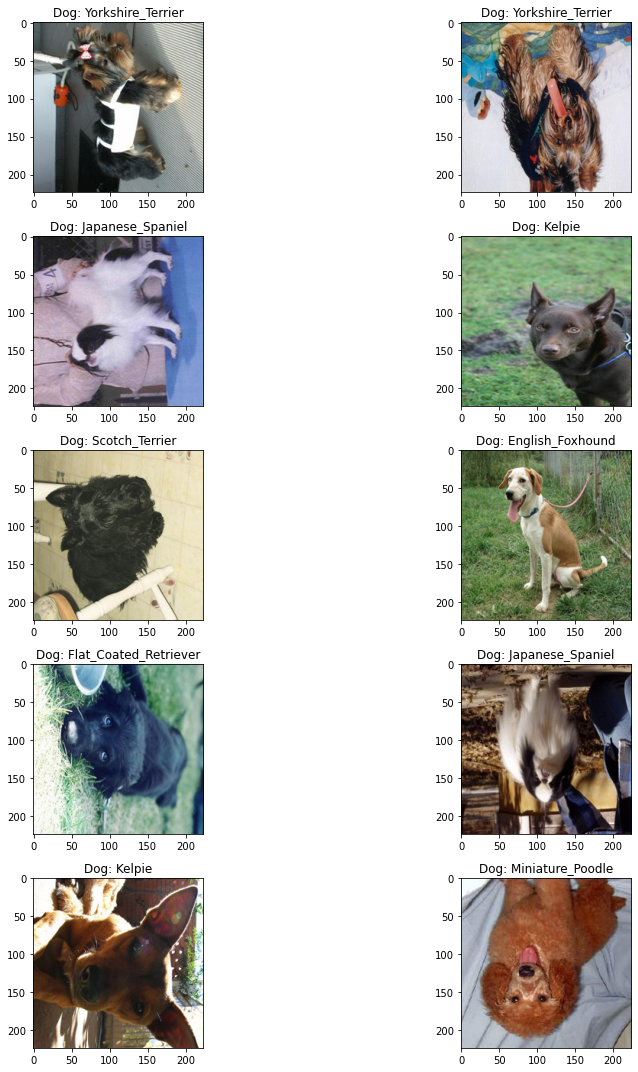

In [5]:
# 1.3 GET SOME IMAGES

fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(labels))
        ax[i,j].imshow(images[l])
        ax[i,j].set_title('Dog: '+labels[l])
plt.tight_layout()

## 2. Data prep

The next step is to prepare the data for training. First, we need to convert the images into arrays. In our case we have 20208 images, whose size is 224x224 and is split into 3 color channels (RGB). The displayed shape of the images confirms this.

In [6]:
# 2.1 ADJUSTING THE DATA TYPES

# Encoding categories as numbers
label_encoder = LabelEncoder()
labels_int = label_encoder.fit_transform(labels)

# Converting lists
X_data = np.array(images)
Y_data = np.array(labels_int)
print("Images shape = ", X_data.shape,
      "\nLabels shape = ", Y_data.shape)
print(type(X_data), type(Y_data))

Images shape =  (20208, 224, 224, 3) 
Labels shape =  (20208,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In order to avoid incorrect label recognition and to make the model more robust, we will shuffle the image order.

In [7]:
# 2.2 SHUFFLE THE DATA

n = np.arange(X_data.shape[0])
np.random.seed(random_seed)
np.random.shuffle(n)
X_data = X_data[n]
Y_data = Y_data[n]
print("Images shape after shuffling = ", X_data.shape,
      "\nLabels shape after shuffling = ", Y_data.shape)

Images shape after shuffling =  (20208, 224, 224, 3) 
Labels shape after shuffling =  (20208,)


Lastly we will normalise data in order to make the learning easier.

In [8]:
# 2.3 NORMALISE THE DATA

X_data = X_data.astype(np.float32)
Y_data = Y_data.astype(np.int32)
X_data = X_data/255
print("Images shape after normalization = ", X_data.shape)

Images shape after normalization =  (20208, 224, 224, 3)


Finally we will split the data into train/test sets as 70 to 30.

In [11]:
# 2.4 SPLIT THE DATA INTO TRAIN/TEST

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=69)
print("X_train shape = ", X_train.shape)
print("Y_train shape = ", Y_train.shape)
print("X_test shape = ", X_test.shape)
print("Y_test shape = ", Y_test.shape)

X_train shape =  (14145, 224, 224, 3)
Y_train shape =  (14145,)
X_test shape =  (6063, 224, 224, 3)
Y_test shape =  (6063,)


Making a backup of the data.

In [24]:
# 2.4 SAVE THE PREPARED DATA

# Train
with open('data/X_train_{}.npy'.format(label_categories), 'wb') as f:
    np.save(f, X_train)   
with open('data/Y_train_{}.npy'.format(label_categories), 'wb') as f:
    np.save(f, Y_train)
    
# Test
with open('data/X_test_{}.npy'.format(label_categories), 'wb') as f:
    np.save(f, X_test)
with open('data/Y_test_{}.npy'.format(label_categories), 'wb') as f:
    np.save(f, Y_test)    

In [4]:
# 2.5 LOAD THE PREPARED DATA

# Train
X_train = np.load('data/X_train_{}.npy'.format(label_categories))
Y_train = np.load('data/Y_train_{}.npy'.format(label_categories))

# Test
X_test = np.load('data/X_test_{}.npy'.format(label_categories))
Y_test = np.load('data/Y_test_{}.npy'.format(label_categories))

# Verify
print("X_train shape = ", X_train.shape)
print("Y_train shape = ", Y_train.shape)
print("X_test shape = ", X_test.shape)
print("Y_test shape = ", Y_test.shape)

X_train shape =  (14145, 224, 224, 3)
Y_train shape =  (14145,)
X_test shape =  (6063, 224, 224, 3)
Y_test shape =  (6063,)


## 3. Models learning from scratch

We will start by training some typical models used for image recognition. There are a lot of network architectures to use but we will limit ourselves to 3 most popular - AlexNet, VGGNet and ResNet. Their differences are shown below.

![title](images/models.jpg)

The following helper functions will plot the learning rate and ROC curve, as well as display image recognition results.

In [5]:
# 3.1 PREPARE FUNCTIONS FOR PLOTTING

# Training history plot
def history_plot(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    ax[0].set_title('Loss')
    ax[0].plot(history.index, history["loss"], label="Train")
    ax[0].plot(history.index, history["val_loss"], label="Validation")
    ax[0].legend()
    
    ax[1].set_title('Accuracy')
    ax[1].plot(history.index, history["accuracy"], label="Train")
    ax[1].plot(history.index, history["val_accuracy"], label="Validation")
    ax[1].legend()

# Plot of some predictions
def predicted_images(prediction):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    labels_txt = label_encoder.inverse_transform(Y_test) 
    for i in range(9):
        n += 1 
        r = np.random.randint( 0, X_test.shape[0], 1)
        plt.subplot(3, 3, n)
        plt.subplots_adjust(hspace = 0.4, wspace = 0.3)
        plt.imshow(X_test[r[0]])

        class_label = labels_txt[r[0]]
        class_actual = Y_test[r[0]]
        class_pred = Y_test[r[0]]*prediction[r[0]][Y_test[r[0]]]

        plt.title('Name = {}, \nActual_class = {}, \nPredicted_class = {}'.format(class_label, class_actual, class_pred),
                                                                                  loc='left')
        plt.xticks([]) , plt.yticks([])
    plt.show()
    
# Plot the ROC curve
def ROC_plot(y_test, y_pred, model_name):
    # roc curve for classes
    fpr = {}
    tpr = {}
    thresh ={}
    roc_auc = {}
    n_classes = Y_test.max()
    
    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test, 
                                              y_pred[:,i], 
                                              pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # plotting 
    plt.figure(figsize=(10,5))
    plt.plot(fpr["macro"], tpr["macro"], linestyle='-', linewidth=3, color='black',
             label='Macro-average (AUC:{})'.format(round(roc_auc["macro"], 2)))
    for i in range(n_classes):     
        plt.plot(fpr[i], tpr[i], linestyle='--', linewidth=1,
                 label='Class {} vs Rest (AUC:{})'.format(i, round(roc_auc[i], 2)))
        
    plt.title('Multiclass ROC curve for {}'.format(model_name))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.show()
    return round(roc_auc["macro"], 2)

In order to ensure that the models have the same conditions for learning, we will add two restrictions - early stopping and learning rate tuning. Both focus on maximizing the accuracy of the model and will terminate the learning process if the results stop improving.

In [7]:
# 3.2 ADD RESTRICTIONS TO AVOID OVERFITTING

# Reduce learning rate if model does not improve
reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                           patience=2, verbose=1, 
                           mode='max', min_delta=0.0001)

# Adding an early stopper
early = EarlyStopping(monitor='val_accuracy', min_delta=0.001, 
                      patience=4, verbose=1,
                      mode='max', baseline = 0.01)

callbacks = [reduce, early]

### 3.1. AlexNet CNN

The first model we will use is AlexNet which was introduced in 2012 and consists of 5 convolution layers, 3 max-pooling layers and 3 fully-connected (dense) layers. It is one of the standard models used for image recognition, which is due to two properties:
- It was the first CNN to use ReLU as activation function, which greatly improved the training speed of deep-learning networks. 
- Additionally AlexNet uses Dropout in the fully-connected (dense) layers which allows to reduce variance in the model results.

![title](images/AlexNet.png)

In [14]:
# 3.1.1 PREPARE THE MODEL STRUCTURE

model_alexnet = Sequential()
#1 conv layer
model_alexnet.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4),
                         padding="valid", activation="relu", 
                         input_shape=(img_size,img_size,3)))
#2 max pool layer
model_alexnet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model_alexnet.add(BatchNormalization())
#3 conv layer
model_alexnet.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1),
                         padding="valid", activation="relu"))
#4 max pool layer
model_alexnet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model_alexnet.add(BatchNormalization())
#5 conv layer
model_alexnet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1),
                         padding="valid", activation="relu"))
#6 conv layer
model_alexnet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1),
                         padding="valid", activation="relu"))
#7 conv layer
model_alexnet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1),
                         padding="valid", activation="relu"))
#8 max pool layer
model_alexnet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model_alexnet.add(BatchNormalization())
model_alexnet.add(Flatten())
#9 dense layer
model_alexnet.add(Dense(4096, input_shape=(img_size,img_size,3),
                        activation="relu"))
model_alexnet.add(Dropout(0.4))
model_alexnet.add(BatchNormalization())
#10 dense layer
model_alexnet.add(Dense(4096, activation="relu"))
model_alexnet.add(Dropout(0.4))
model_alexnet.add(BatchNormalization())
#11 dense layer
model_alexnet.add(Dense(1000, activation="relu"))
model_alexnet.add(Dropout(0.4))
model_alexnet.add(BatchNormalization())
#12 output layer
model_alexnet.add(Dense(label_categories, activation="softmax"))
model_alexnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 384)         8

In [15]:
# 3.1.2 TRAIN THE MODEL 

# Compile
model_alexnet.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train 
start_time = datetime.now()
history_alexnet = model_alexnet.fit(X_train, Y_train,
                                    validation_data = (X_test, Y_test),
                                    epochs = 100, 
                                    batch_size = batch_size,
                                    validation_batch_size = batch_size,
                                    callbacks = callbacks)
end_time = datetime.now()
alexnet_time = end_time - start_time
print('Total time taken: ', str(alexnet_time))

Epoch 1/100
443/443 [==============================] - 647s 1s/step - loss: 2.4264 - accuracy: 0.1984 - val_loss: 2.0863 - val_accuracy: 0.2651
Epoch 2/100
443/443 [==============================] - 638s 1s/step - loss: 2.0809 - accuracy: 0.2653 - val_loss: 3.1257 - val_accuracy: 0.2502
Epoch 3/100
443/443 [==============================] - ETA: 0s - loss: 1.9113 - accuracy: 0.3125
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
443/443 [==============================] - 1129s 3s/step - loss: 1.9113 - accuracy: 0.3125 - val_loss: 2.2999 - val_accuracy: 0.2263
Epoch 4/100
443/443 [==============================] - 639s 1s/step - loss: 1.6499 - accuracy: 0.4033 - val_loss: 1.6005 - val_accuracy: 0.4473
Epoch 5/100
443/443 [==============================] - 620s 1s/step - loss: 1.5485 - accuracy: 0.4445 - val_loss: 1.4896 - val_accuracy: 0.4770
Epoch 6/100
443/443 [==============================] - 613s 1s/step - loss: 1.4755 - accuracy: 0.4766 - val_loss:

In [16]:
# 3.1.3 SAVE MODEL AND HISTORY

# Model
model_alexnet.save('models/alexnet', overwrite=True)

# History
history_alexnet_df = pd.DataFrame(history_alexnet.history) 
with open('models/history_alexnet.csv', mode='w') as f:
    history_alexnet_df.to_csv(f, sep = ';')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/alexnet\assets


In [17]:
# 3.1.4 LOAD MODEL AND HISTORY

# Model
model_alexnet = load_model('models/alexnet')

# History
history_alexnet = pd.read_csv('models/history_alexnet.csv', sep = ';')

Alexnet accuracy:  0.915553331375122 
Alexnet loss:  0.2592708468437195


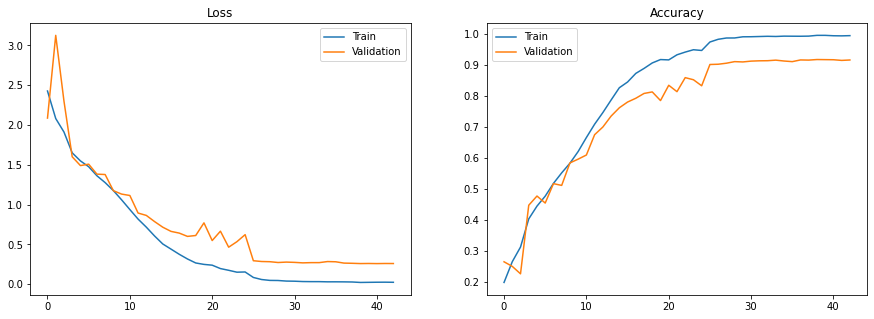

In [18]:
# 3.1.5 EVALUATE THE MODEL 

# Model evaluation 
loss_alexnet, accuracy_alexnet = history_alexnet[['val_loss','val_accuracy']].values[-1]
print("Alexnet accuracy: ", accuracy_alexnet,
      "\nAlexnet loss: ", loss_alexnet)

# results visualisation
history_plot(history_alexnet)

(6063, 10)


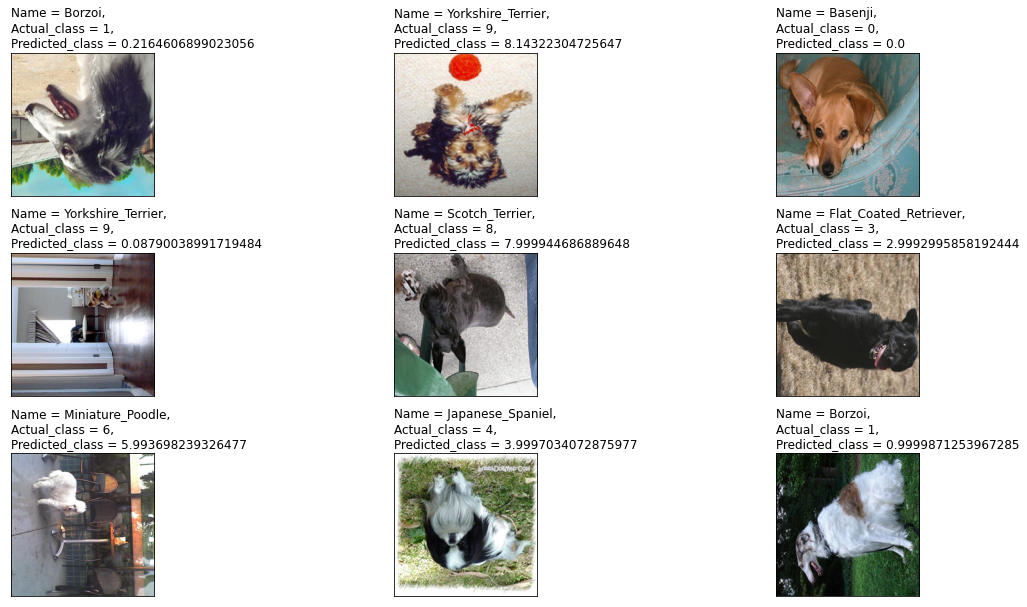

In [19]:
# 3.1.6 MAKE PREDICTION

# Prediction 
pred_alexnet = model_alexnet.predict(X_test)
print(pred_alexnet.shape)

# Prediction visualisation
predicted_images(pred_alexnet)

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       755
           1       0.89      0.88      0.89       522
           2       0.94      0.92      0.93       565
           3       0.87      0.90      0.88       517
           4       0.93      0.95      0.94       705
           5       0.90      0.90      0.90       572
           6       0.93      0.90      0.91       562
           7       0.91      0.91      0.91       711
           8       0.91      0.92      0.92       573
           9       0.91      0.93      0.92       581

    accuracy                           0.92      6063
   macro avg       0.91      0.91      0.91      6063
weighted avg       0.92      0.92      0.92      6063



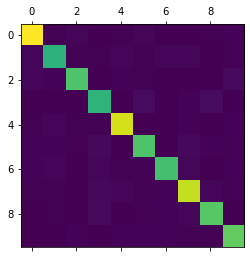

In [20]:
# 3.1.7 PRINT THE CONFUSION MATRIX

plt.matshow(confusion_matrix(Y_test, pred_alexnet.argmax(axis=1)))
print(classification_report(Y_test, pred_alexnet.argmax(axis=1)))

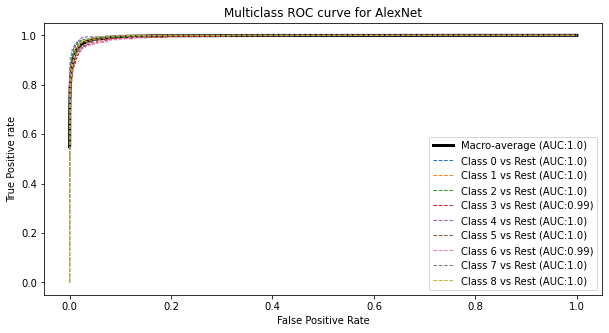

In [21]:
# 3.1.8 PLOT THE ROC CURVE

auc_alexnet = ROC_plot(y_test=Y_test, y_pred=pred_alexnet, model_name='AlexNet')

### 3.2. VGG16

Next we will try to train a deeper network called VGGNet.

The VCGNet became popular in 2014 and proposed a deeper architecture than AlexNet.  Some of the noticeable new concepts are:
- heavily used 3 x 3 filters for convolution layers (replacing 5 x 5 or 7 x 7 filters to have wider scanning areas and reduce numbers of parameters),
- 1 x 1 filters for nonlinear transformations, doubling number of channels after each pooling layer to recover lost information from the pooling layers.

However, there are two major drawbacks with VGGNet:
- It is painfully slow to train.
- The network architecture weights themselves are quite large (concerning disk/bandwidth)

![title](images/VGGNet.png)

In [27]:
# 3.2.1 PREPARE THE MODEL STRUCTURE

model_vgg16 = Sequential()

#Conv Block 1
model_vgg16.add(Conv2D(input_shape=(img_size,img_size,3), filters=64, kernel_size=(3,3),
                       padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=64, kernel_size=(3,3),
                       padding="same", activation="relu"))
model_vgg16.add(MaxPool2D(pool_size=(2,2), strides=(2,2),
                       padding="same"))

#Conv Block 2
model_vgg16.add(Conv2D(filters=128, kernel_size=(3,3), 
                       padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=128, kernel_size=(3,3), 
                       padding="same", activation="relu"))
model_vgg16.add(MaxPool2D(pool_size=(2,2), strides=(2,2),
                       padding="same"))

#Conv Block 3
model_vgg16.add(Conv2D(filters=256, kernel_size=(3,3), 
                       padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=256, kernel_size=(3,3), 
                       padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=256, kernel_size=(3,3), 
                       padding="same", activation="relu"))
model_vgg16.add(MaxPool2D(pool_size=(2,2), strides=(2,2),
                       padding="same"))

#Conv Block 4
model_vgg16.add(Conv2D(filters=512, kernel_size=(3,3), 
                       padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=512, kernel_size=(3,3), 
                       padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=512, kernel_size=(3,3), 
                       padding="same", activation="relu"))
model_vgg16.add(MaxPool2D(pool_size=(2,2), strides=(2,2),
                       padding="same"))

#Conv Block 5
model_vgg16.add(Conv2D(filters=512, kernel_size=(3,3), 
                       padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=512, kernel_size=(3,3), 
                       padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=512, kernel_size=(3,3), 
                       padding="same", activation="relu"))
model_vgg16.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Fully connected layers
model_vgg16.add(Flatten())
model_vgg16.add(Dense(4096, activation="relu"))
model_vgg16.add(Dense(4096, activation="relu"))
model_vgg16.add(Dense(label_categories, activation="softmax"))

model_vgg16.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 56, 56, 256)      

In [28]:
# 3.2.2 TRAIN THE MODEL 

# Compile
model_vgg16.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train 
start_time = datetime.now()
history_vgg16 = model_vgg16.fit(X_train, Y_train,
                                validation_data = (X_test, Y_test),
                                epochs = 100, 
                                batch_size = batch_size,
                                validation_batch_size = batch_size,
                                callbacks = callbacks)
end_time = datetime.now()
vgg16_time = end_time - start_time
print('Total time taken: ', str(vgg16_time))

Epoch 1/100
443/443 [==============================] - 10394s 23s/step - loss: 2.3179 - accuracy: 0.1235 - val_loss: 2.2958 - val_accuracy: 0.1245
Epoch 2/100
443/443 [==============================] - 10725s 24s/step - loss: 2.2970 - accuracy: 0.1210 - val_loss: 2.2954 - val_accuracy: 0.1245
Epoch 3/100
443/443 [==============================] - ETA: 0s - loss: 2.2968 - accuracy: 0.1239 
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
443/443 [==============================] - 10739s 24s/step - loss: 2.2968 - accuracy: 0.1239 - val_loss: 2.2954 - val_accuracy: 0.1245
Epoch 4/100
443/443 [==============================] - 10297s 23s/step - loss: 2.2961 - accuracy: 0.1239 - val_loss: 2.2951 - val_accuracy: 0.1245
Epoch 5/100
443/443 [==============================] - ETA: 0s - loss: 2.2960 - accuracy: 0.1239 
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
443/443 [==============================] - 11250s 25s/step - loss:

In [29]:
# 3.2.3 SAVE MODEL AND HISTORY

# Model
model_vgg16.save('models/vgg16', overwrite=True)

# History
history_vgg16_df = pd.DataFrame(history_vgg16.history) 
with open('models/history_vgg16.csv', mode='w') as f:
    history_vgg16_df.to_csv(f, sep = ';')

INFO:tensorflow:Assets written to: models/vgg16\assets


In [30]:
# 3.2.4 LOAD MODEL AND HISTORY

# Model
model_vgg16 = load_model('models/vgg16')

# History
history_vgg16 = pd.read_csv('models/history_vgg16.csv', sep = ';')

VGG16 accuracy:  0.1245258152484893 
VGG16 loss:  2.294981002807617


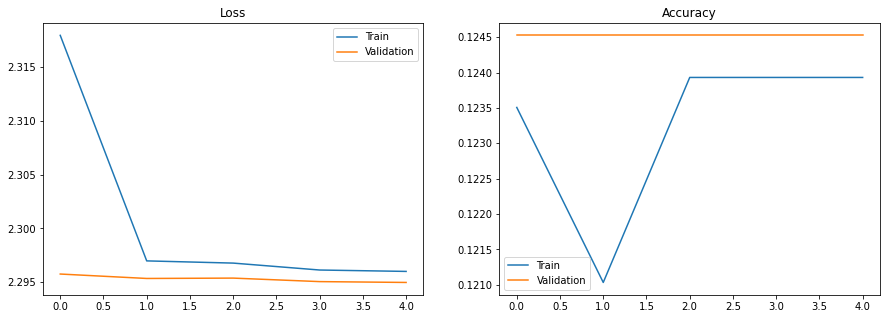

In [31]:
# 3.2.5 EVALUATE THE MODEL

# Model evaluation 
loss_vgg16, accuracy_vgg16 = history_vgg16[['val_loss','val_accuracy']].values[-1]
print("VGG16 accuracy: ", accuracy_vgg16,
      "\nVGG16 loss: ", loss_vgg16)

# results visualisation
history_plot(history_vgg16)

(6063, 10)


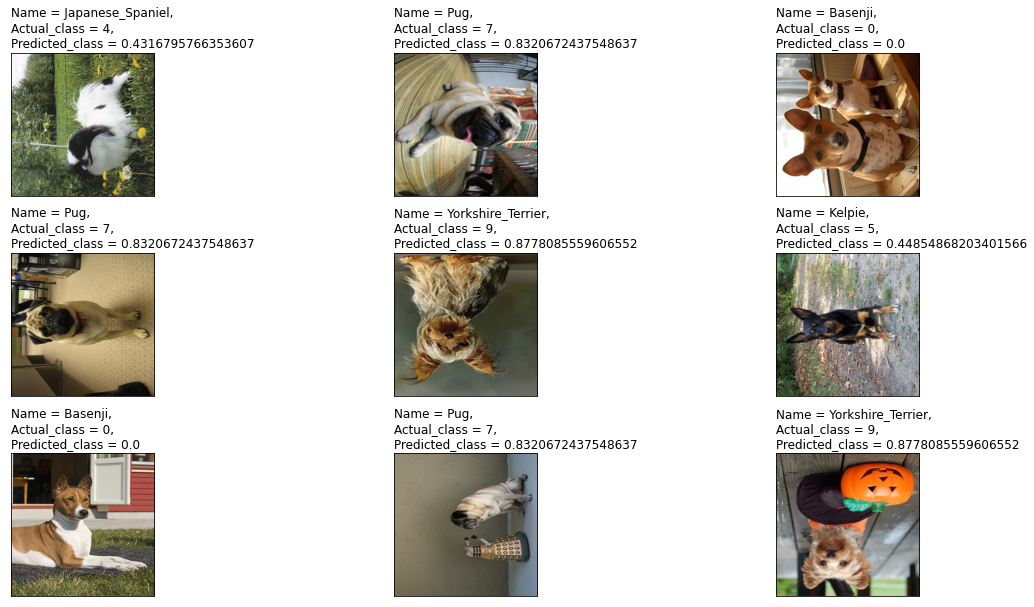

In [32]:
# 3.2.6 MAKE PREDICTION

# Prediction 
pred_vgg16 = model_vgg16.predict(X_test)
print(pred_vgg16.shape)

# Prediction visualisation
predicted_images(pred_vgg16)

              precision    recall  f1-score   support

           0       0.12      1.00      0.22       755
           1       0.00      0.00      0.00       522
           2       0.00      0.00      0.00       565
           3       0.00      0.00      0.00       517
           4       0.00      0.00      0.00       705
           5       0.00      0.00      0.00       572
           6       0.00      0.00      0.00       562
           7       0.00      0.00      0.00       711
           8       0.00      0.00      0.00       573
           9       0.00      0.00      0.00       581

    accuracy                           0.12      6063
   macro avg       0.01      0.10      0.02      6063
weighted avg       0.02      0.12      0.03      6063



C:\Users\qn74bk\Python\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qn74bk\Python\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qn74bk\Python\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


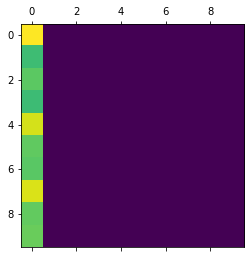

In [33]:
# 3.2.7 PRINT THE CONFUSION MATRIX

plt.matshow(confusion_matrix(Y_test, pred_vgg16.argmax(axis=1)))
print(classification_report(Y_test, pred_vgg16.argmax(axis=1)))

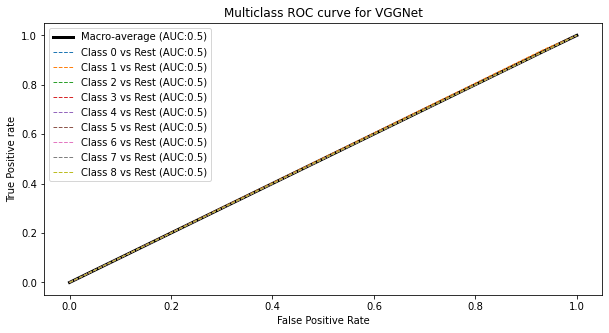

In [34]:
# 3.2.8 PLOT THE ROC CURVE

auc_vgg16 = ROC_plot(y_test=Y_test, y_pred=pred_vgg16, model_name='VGGNet')

### 3.3. ResNet50

The previous model wasn`t able to learn any features of the dataset. We will try the ResNet model which is an improvement of VGGNet architecture.

One of the problems of previous networks is that deeper networks are much harder to optimize due to the notorious problem of vanishing/exploding gradients. ResNet tries to adress this problem by introducing the Residual Learning concept. 

It is built on the VGG network, but uses so called residual blocks to create identity shortcut connections between the layers. A residual block is a pattern of two convolutional layers with ReLU activation where the output of the block is combined with the input to the block. As a result, these blocks create connections in the network architecture where the input is kept as-is (not weighted) and passed on to a deeper layer, e.g. skipping the next layer.

For the purposes of this task, we will create two types of blocks: 
- The identity block is the standard block used in ResNets and corresponds to the case where the input activation has the same dimension as the output activation.
![title](images/ResNet_Iden.png)
- On the other hand, the convolutional block will be used when the input and output dimensions don’t match up. unlike the identity block, it will have a CONV2D layer in the shortcut path.
![title](images/ResNet_Conv.png)

Overall, the ResNet50 model consists of 5 stages each with a convolution and identity block. Each convolution block has 3 convolution layers and each identity block also has 3 convolution layers.
![title](images/ResNet.png)

In [6]:
# 3.3.1 PREPARE THE MODEL STRUCTURE

# Implementation of Identity Block
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    # Shortcut
    X_shortcut = X
   
    # Stage 1
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Stage 2
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # Stage 3
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    
    # Output
    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

# Implementation of Convolutional Block
def convolutional_block(X, f, filters, stage, block, s=2):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters
    
    # Shortcut
    X_shortcut = X
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)
    
    # Stage 1
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Stage 2
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # Stage 3
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Output
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

# Implementation of ResNet-50
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    # Input
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    
    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    
    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    
    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # Output
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model


# Implementation of the fully connected layer
model_resnet = Sequential()
model_resnet.add(ResNet50(input_shape=(img_size,img_size,3)))
model_resnet.add(Flatten())
model_resnet.add(Dense(256, activation='relu', name='fc1', 
                       kernel_initializer=glorot_uniform(seed=0)))
model_resnet.add(Dropout(0.4))
model_resnet.add(Dense(128, activation='relu', name='fc2', 
                       kernel_initializer=glorot_uniform(seed=0)))
model_resnet.add(Dropout(0.4))
model_resnet.add(Dense(label_categories, activation='sigmoid', name='fc3',
                       kernel_initializer=glorot_uniform(seed=0)))

model_resnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ResNet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 256)               8388864   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
fc3 (Dense)                  (None, 10)                1

In [7]:
# 3.3.2 TRAIN THE MODEL 

# Compile
model_resnet.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train 
start_time = datetime.now()
history_resnet = model_resnet.fit(X_train, Y_train,
                                  validation_data = (X_test, Y_test),
                                  epochs = 100, 
                                  batch_size = batch_size,
                                  validation_batch_size = batch_size,
                                  callbacks = callbacks)
end_time = datetime.now()
resnet_time = end_time - start_time
print('Total time taken: ', str(resnet_time))

Epoch 1/100
443/443 [==============================] - 6361s 14s/step - loss: 2.5227 - accuracy: 0.1074 - val_loss: 2.3026 - val_accuracy: 0.1245
Epoch 2/100
443/443 [==============================] - 6295s 14s/step - loss: 2.3512 - accuracy: 0.1231 - val_loss: 2.3026 - val_accuracy: 0.1245
Epoch 3/100
443/443 [==============================] - ETA: 0s - loss: 2.3170 - accuracy: 0.1227 
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
443/443 [==============================] - 6304s 14s/step - loss: 2.3170 - accuracy: 0.1227 - val_loss: 2.3026 - val_accuracy: 0.1245
Epoch 4/100
443/443 [==============================] - 6311s 14s/step - loss: 2.3056 - accuracy: 0.1209 - val_loss: 2.3026 - val_accuracy: 0.1245
Epoch 5/100
443/443 [==============================] - ETA: 0s - loss: 2.3038 - accuracy: 0.1211 
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
443/443 [==============================] - 6525s 15s/step - loss: 2.30

In [8]:
# 3.3.3 SAVE MODEL AND HISTORY

# Model
model_resnet.save('models/resnet', overwrite=True)

# History
history_resnet_df = pd.DataFrame(history_resnet.history) 
with open('models/history_resnet.csv', mode='w') as f:
    history_resnet_df.to_csv(f, sep = ';')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/resnet\assets


In [9]:
# 3.3.4 LOAD MODEL AND HISTORY

# Model
model_resnet = load_model('models/resnet')

# History
history_resnet = pd.read_csv('models/history_resnet.csv', sep = ';')

Resnet accuracy:  0.1245258152484893 
Resnet loss:  2.3025825023651123


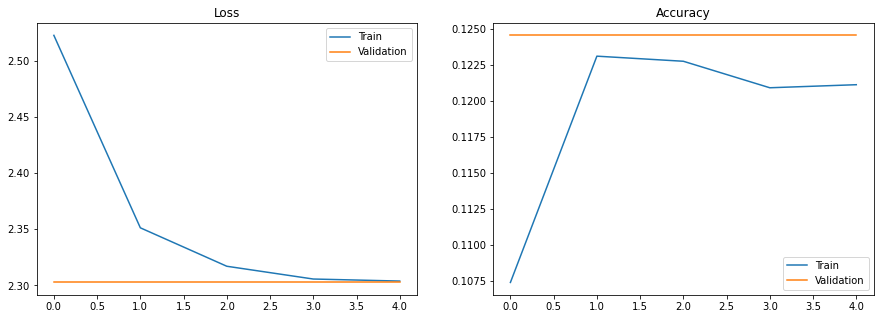

In [10]:
# 3.3.5 EVALUATE THE MODEL

# Model evaluation 
loss_resnet, accuracy_resnet = history_resnet[['val_loss','val_accuracy']].values[-1]
print("Resnet accuracy: ", accuracy_resnet,
      "\nResnet loss: ", loss_resnet)

# results visualisation
history_plot(history_resnet)

(6063, 10)


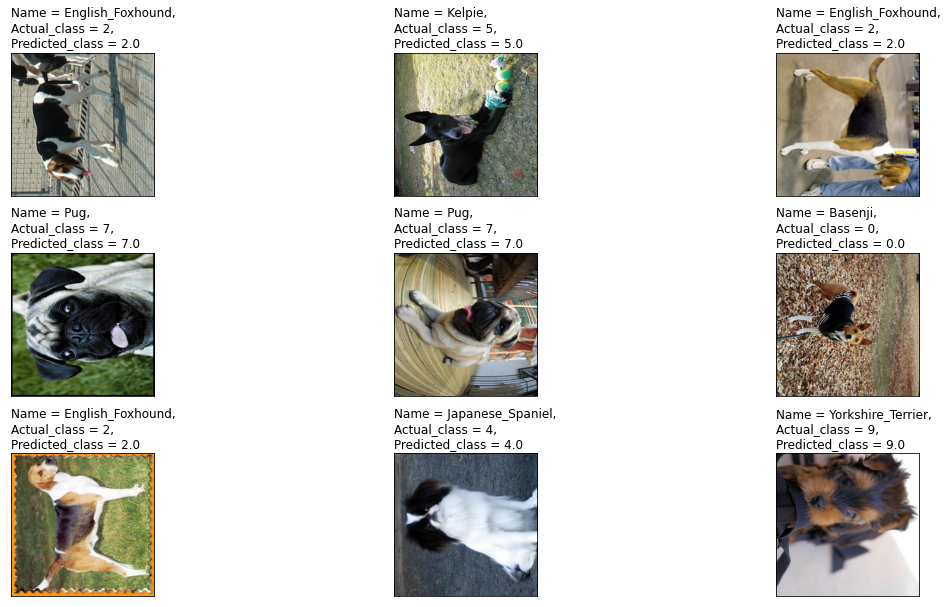

In [15]:
# 3.3.6 MAKE PREDICTION

# Prediction 
pred_resnet = model_resnet.predict(X_test)
print(pred_resnet.shape)

# Prediction visualisation
predicted_images(pred_resnet)

              precision    recall  f1-score   support

           0       0.12      1.00      0.22       755
           1       0.00      0.00      0.00       522
           2       0.00      0.00      0.00       565
           3       0.00      0.00      0.00       517
           4       0.00      0.00      0.00       705
           5       0.00      0.00      0.00       572
           6       0.00      0.00      0.00       562
           7       0.00      0.00      0.00       711
           8       0.00      0.00      0.00       573
           9       0.00      0.00      0.00       581

    accuracy                           0.12      6063
   macro avg       0.01      0.10      0.02      6063
weighted avg       0.02      0.12      0.03      6063



C:\Users\qn74bk\Python\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qn74bk\Python\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qn74bk\Python\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


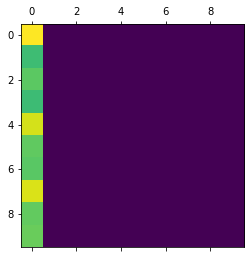

In [16]:
# 3.3.7 PRINT THE CONFUSION MATRIX

plt.matshow(confusion_matrix(Y_test, pred_resnet.argmax(axis=1)))
print(classification_report(Y_test, pred_resnet.argmax(axis=1)))

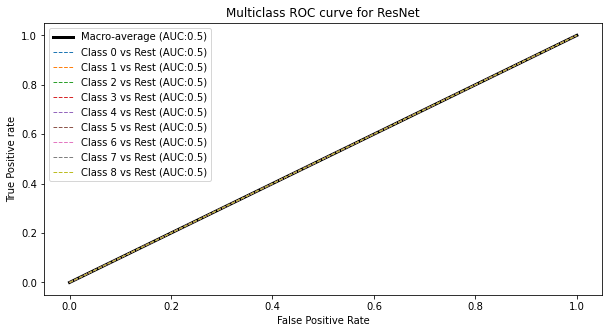

In [17]:
# 3.3.8 PLOT THE ROC CURVE

auc_resnet = ROC_plot(y_test=Y_test, y_pred=pred_resnet, model_name='ResNet')

## 4. Transfer learning

The models used in the previous section had some issues when learning on the dataset. Success of AlexNet and failure of the other two suggests that deeper models do not have sufficient data to extract features. To mitigate this problem, we will try to use transfer learning on pre-trained models.

### 4.1 ResNet pre-trained

In order to test this, we will use the ResNet architecture from the previous section, but this time we will apply weights previously learned on a diferent dataset. Keras allows us to import this pre-trained model where we will re-train only the last (dense) layers.

In [10]:
# 4.1.2 TRAIN THE MODEL 

# Compile
model_resnet_transfer.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train 
start_time = datetime.now()
history_resnet_transfer = model_resnet_transfer.fit(X_train, Y_train,
                                                    validation_data = (X_test, Y_test),
                                                    epochs = 100, 
                                                    batch_size = batch_size,
                                                    validation_batch_size = batch_size,
                                                    callbacks = callbacks)
end_time = datetime.now()
resnet_transfer_time = end_time - start_time
print('Total time taken: ', str(resnet_transfer_time))

Epoch 1/100
443/443 [==============================] - 1436s 3s/step - loss: 2.3124 - accuracy: 0.1258 - val_loss: 2.2580 - val_accuracy: 0.1545
Epoch 2/100
443/443 [==============================] - 1367s 3s/step - loss: 2.2739 - accuracy: 0.1308 - val_loss: 2.2840 - val_accuracy: 0.1280
Epoch 3/100
443/443 [==============================] - 1551s 4s/step - loss: 2.2708 - accuracy: 0.1305 - val_loss: 2.2549 - val_accuracy: 0.1583
Epoch 4/100
443/443 [==============================] - 1512s 3s/step - loss: 2.2645 - accuracy: 0.1379 - val_loss: 2.2413 - val_accuracy: 0.1715
Epoch 5/100
443/443 [==============================] - 1559s 4s/step - loss: 2.2668 - accuracy: 0.1286 - val_loss: 2.2481 - val_accuracy: 0.1463
Epoch 6/100
443/443 [==============================] - 1533s 3s/step - loss: 2.2563 - accuracy: 0.1417 - val_loss: 2.2384 - val_accuracy: 0.1732
Epoch 7/100
443/443 [==============================] - 1525s 3s/step - loss: 2.2591 - accuracy: 0.1446 - val_loss: 2.2547 - val_ac

In [11]:
# 4.1.3 SAVE MODEL AND HISTORY

# Model
model_resnet_transfer.save('models/resnet_transfer', overwrite=True)

# History
history_resnet_transfer_df = pd.DataFrame(history_resnet_transfer.history) 
with open('models/history_resnet_transfer.csv', mode='w') as f:
    history_resnet_transfer_df.to_csv(f, sep = ';')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/resnet_transfer\assets


In [12]:
# 4.1.4 LOAD MODEL AND HISTORY

# Model
model_resnet_transfer = load_model('models/resnet_transfer')

# History
history_resnet_transfer = pd.read_csv('models/history_resnet_transfer.csv', sep = ';')

Resnet transfer accuracy:  0.2144153118133545 
Resnet transfer loss:  2.207352876663208


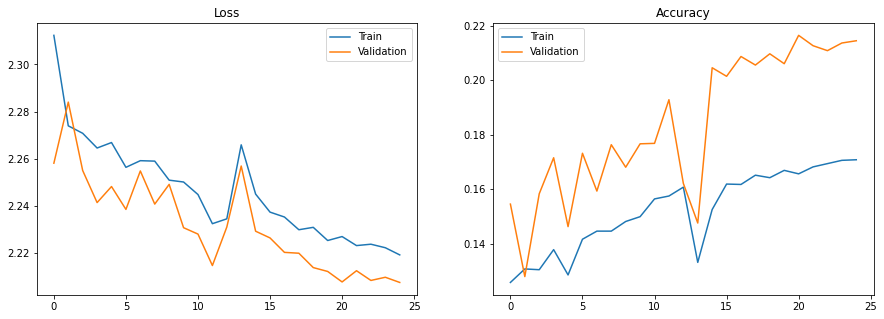

In [13]:
# 4.1.5 EVALUATE THE MODEL

# Model evaluation 
loss_resnet_transfer, accuracy_resnet_transfer = history_resnet_transfer[['val_loss','val_accuracy']].values[-1]
print("Resnet transfer accuracy: ", accuracy_resnet_transfer,
      "\nResnet transfer loss: ", loss_resnet_transfer)

# results visualisation
history_plot(history_resnet_transfer)

(6063, 10)


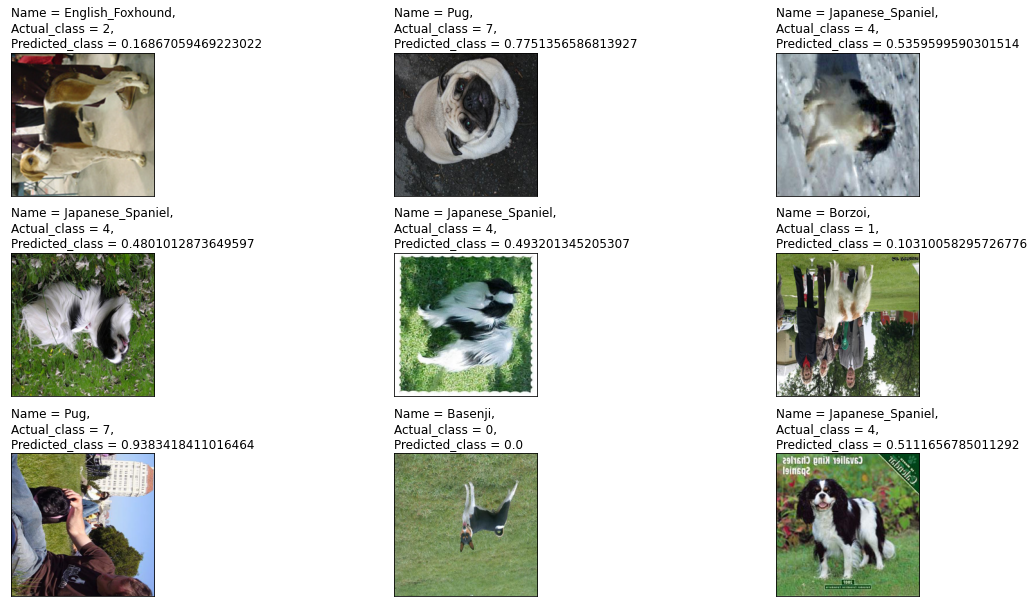

In [14]:
# 4.1.6 MAKE PREDICTION

# Prediction 
pred_resnet_transfer = model_resnet_transfer.predict(X_test)
print(pred_resnet_transfer.shape)

# Prediction visualisation
predicted_images(pred_resnet_transfer)

              precision    recall  f1-score   support

           0       0.21      0.62      0.31       755
           1       0.00      0.00      0.00       522
           2       0.65      0.03      0.06       565
           3       0.00      0.00      0.00       517
           4       0.28      0.48      0.35       705
           5       0.00      0.00      0.00       572
           6       0.22      0.64      0.32       562
           7       0.13      0.15      0.14       711
           8       0.00      0.00      0.00       573
           9       0.13      0.02      0.03       581

    accuracy                           0.21      6063
   macro avg       0.16      0.19      0.12      6063
weighted avg       0.17      0.21      0.13      6063



C:\Users\qn74bk\Python\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qn74bk\Python\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qn74bk\Python\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


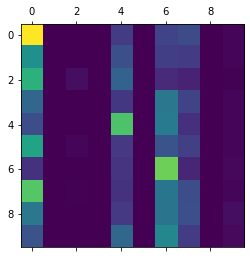

In [15]:
# 4.1.7 PRINT THE CONFUSION MATRIX

plt.matshow(confusion_matrix(Y_test, pred_resnet_transfer.argmax(axis=1)))
print(classification_report(Y_test, pred_resnet_transfer.argmax(axis=1)))

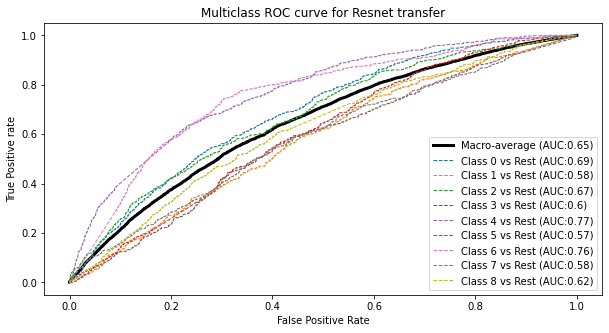

In [16]:
# 4.1.8 PLOT THE ROC CURVE

auc_resnet_transfer = ROC_plot(y_test=Y_test, y_pred=pred_resnet_transfer, model_name='Resnet transfer')

### 4.2. DenseNet121

DenseNet is based on the ResNet model and also adresses the problem of vanishing/exploding gradients. However, while ResNets residual blocks skip only one layer, DenseNet obtains additional inputs from all preceding layers and passes its own feature-maps to all subsequent layers. In other words, each layer is receiving “collective knowledge” from all preceding layers.

Structure of ResNet:
![title](images/ResNet_logic.png)
Structure of DenseNet:
![title](images/DenseNet.png)

Its main advantages are that it has higher computational and memory efficiency. Additionally, since it recieves information from all previous layers, its features are more divercified and tend to have richer patterns.

In [18]:
# 4.2.1 PREPARE THE MODEL STRUCTURE

# base model
base_model_densenet = DenseNet121(weights='imagenet', 
                                  include_top=False, 
                                  input_shape=(img_size,img_size,3))

# final model
model_densenet = Sequential()
model_densenet.add(base_model_densenet)
model_densenet.add(GlobalAveragePooling2D())
model_densenet.add(Dense(1024, activation="relu"))
model_densenet.add(Dropout(0.5))
model_densenet.add(Dense(1024, activation="relu"))
model_densenet.add(Dropout(0.5))
model_densenet.add(Dense(label_categories, activation= 'softmax'))

# retrain only the last (added) layers
for layer in model_densenet.layers[:-6]:
    layer.trainable = False
                
model_densenet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

In [19]:
# 4.2.2 TRAIN THE MODEL 

# Compile
model_densenet.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train 
start_time = datetime.now()
history_densenet = model_densenet.fit(X_train, Y_train,
                                      validation_data = (X_test, Y_test),
                                      epochs = 100, 
                                      batch_size = batch_size,
                                      validation_batch_size = batch_size,
                                      callbacks = callbacks)
end_time = datetime.now()
densenet_time = end_time - start_time
print('Total time taken: ', str(densenet_time))

Epoch 1/100
443/443 [==============================] - 1444s 3s/step - loss: 0.6555 - accuracy: 0.7817 - val_loss: 0.2554 - val_accuracy: 0.9225
Epoch 2/100
443/443 [==============================] - 1430s 3s/step - loss: 0.3693 - accuracy: 0.8758 - val_loss: 0.2089 - val_accuracy: 0.9304
Epoch 3/100
443/443 [==============================] - 1445s 3s/step - loss: 0.2877 - accuracy: 0.9043 - val_loss: 0.1486 - val_accuracy: 0.9525
Epoch 4/100
443/443 [==============================] - 1447s 3s/step - loss: 0.2404 - accuracy: 0.9205 - val_loss: 0.1559 - val_accuracy: 0.9476
Epoch 5/100
443/443 [==============================] - 1451s 3s/step - loss: 0.2102 - accuracy: 0.9313 - val_loss: 0.1033 - val_accuracy: 0.9668
Epoch 6/100
443/443 [==============================] - 1466s 3s/step - loss: 0.2047 - accuracy: 0.9320 - val_loss: 0.1409 - val_accuracy: 0.9512
Epoch 7/100
443/443 [==============================] - ETA: 0s - loss: 0.1837 - accuracy: 0.9396
Epoch 00007: ReduceLROnPlateau re

In [20]:
# 4.2.3 SAVE MODEL AND HISTORY

# Model
model_densenet.save('models/densenet', overwrite=True)

# History
history_densenet_df = pd.DataFrame(history_densenet.history) 
with open('models/history_densenet.csv', mode='w') as f:
    history_densenet_df.to_csv(f, sep = ';')

INFO:tensorflow:Assets written to: models/densenet\assets


In [21]:
# 4.2.4 LOAD MODEL AND HISTORY

# Model
model_densenet = load_model('models/densenet')

# History
history_densenet = pd.read_csv('models/history_densenet.csv', sep = ';')

Densenet accuracy:  0.9901039004325868 
Densenet loss:  0.0309041738510131


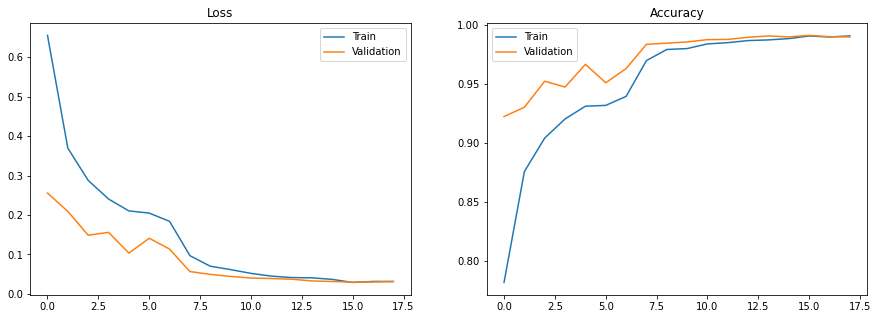

In [22]:
# 4.2.5 EVALUATE THE MODEL

# Model evaluation 
loss_densenet, accuracy_densenet = history_densenet[['val_loss','val_accuracy']].values[-1]
print("Densenet accuracy: ", accuracy_densenet,
      "\nDensenet loss: ", loss_densenet)

# results visualisation
history_plot(history_densenet)

(6063, 10)


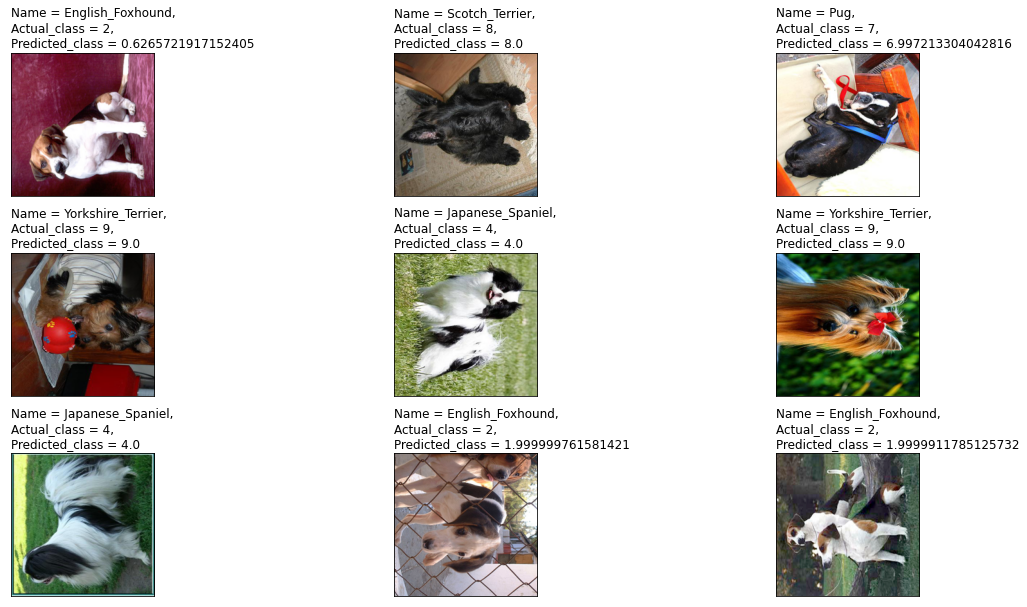

In [23]:
# 4.2.6 MAKE PREDICTION

# Prediction 
pred_densenet = model_densenet.predict(X_test)
print(pred_densenet.shape)

# Prediction visualisation
predicted_images(pred_densenet)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       755
           1       0.99      1.00      0.99       522
           2       0.99      0.99      0.99       565
           3       0.98      0.99      0.99       517
           4       1.00      0.99      1.00       705
           5       0.97      0.99      0.98       572
           6       0.99      0.99      0.99       562
           7       0.98      1.00      0.99       711
           8       0.99      0.99      0.99       573
           9       1.00      0.99      0.99       581

    accuracy                           0.99      6063
   macro avg       0.99      0.99      0.99      6063
weighted avg       0.99      0.99      0.99      6063



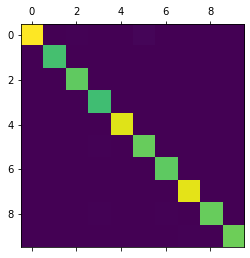

In [24]:
# 4.2.7 PRINT THE CONFUSION MATRIX

plt.matshow(confusion_matrix(Y_test, pred_densenet.argmax(axis=1)))
print(classification_report(Y_test, pred_densenet.argmax(axis=1)))

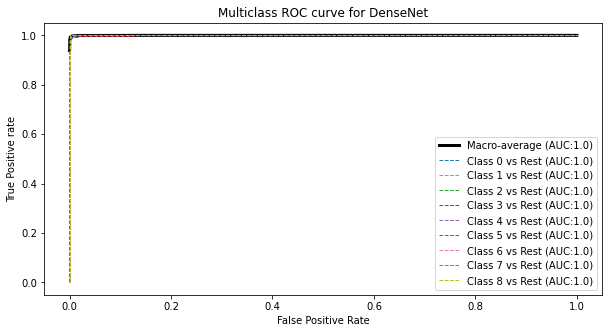

In [25]:
# 4.2.8 PLOT THE ROC CURVE

auc_densenet = ROC_plot(y_test=Y_test, y_pred=pred_densenet, model_name='DenseNet')

### 4.3. NasNetMobile

NasNet was introduced by Google and approaches the task of image recognition as a Reinforcement Learning problem. Its idea is to search the best combination of parameters in the given search space consisting of filter sizes, output channels, strides, number of layers, etc. The reward after each search action was the accuracy for the searched architecture on the given dataset.

It is able to achieve very high results in image recognition. However, NASNet requires very large computation power, so we will use a pre-trained model and apply transfer learning.

In [26]:
# 4.3.1 PREPARE THE MODEL STRUCTURE

# base model
base_model_nasnet = NASNetMobile(weights='imagenet', 
                                 include_top=False, 
                                 input_shape=(img_size,img_size,3))

# final model
model_nasnet = Sequential()
model_nasnet.add(base_model_nasnet)
model_nasnet.add(GlobalAveragePooling2D())
model_nasnet.add(Dense(1024, activation="relu"))
model_nasnet.add(Dropout(0.5))
model_nasnet.add(Dense(1024, activation="relu"))
model_nasnet.add(Dropout(0.5))
model_nasnet.add(Dense(label_categories, activation= 'softmax'))

# retrain only the last (added) layers
for layer in model_nasnet.layers[:-6]:
    layer.trainable = False
                
model_nasnet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1056)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1082368   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

In [27]:
# 4.3.2 TRAIN THE MODEL 

# Compile
model_nasnet.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train 
start_time = datetime.now()
history_nasnet = model_nasnet.fit(X_train, Y_train,
                                  validation_data = (X_test, Y_test),
                                  epochs = 100, 
                                  batch_size = batch_size,
                                  validation_batch_size = batch_size,
                                  callbacks = callbacks)
end_time = datetime.now()
nasnet_time = end_time - start_time
print('Total time taken: ', str(nasnet_time))

Epoch 1/100
443/443 [==============================] - 886s 2s/step - loss: 0.4895 - accuracy: 0.8375 - val_loss: 0.2624 - val_accuracy: 0.9062
Epoch 2/100
443/443 [==============================] - 934s 2s/step - loss: 0.2865 - accuracy: 0.9022 - val_loss: 0.2033 - val_accuracy: 0.9271
Epoch 3/100
443/443 [==============================] - 949s 2s/step - loss: 0.2206 - accuracy: 0.9255 - val_loss: 0.1853 - val_accuracy: 0.9316
Epoch 4/100
443/443 [==============================] - 934s 2s/step - loss: 0.1879 - accuracy: 0.9386 - val_loss: 0.1185 - val_accuracy: 0.9607
Epoch 5/100
443/443 [==============================] - 892s 2s/step - loss: 0.1629 - accuracy: 0.9468 - val_loss: 0.1056 - val_accuracy: 0.9629
Epoch 6/100
443/443 [==============================] - 889s 2s/step - loss: 0.1570 - accuracy: 0.9477 - val_loss: 0.1041 - val_accuracy: 0.9654
Epoch 7/100
443/443 [==============================] - 886s 2s/step - loss: 0.1390 - accuracy: 0.9551 - val_loss: 0.1051 - val_accuracy:

In [28]:
# 4.3.3 SAVE MODEL AND HISTORY

# Model
model_nasnet.save('models/nasnet', overwrite=True)

# History
history_nasnet_df = pd.DataFrame(history_nasnet.history) 
with open('models/history_nasnet.csv', mode='w') as f:
    history_nasnet_df.to_csv(f, sep = ';')

INFO:tensorflow:Assets written to: models/nasnet\assets


In [29]:
# 4.3.4 LOAD MODEL AND HISTORY

# Model
model_nasnet = load_model('models/nasnet')

# History
history_nasnet = pd.read_csv('models/history_nasnet.csv', sep = ';')

Nasnet accuracy:  0.9904337525367736 
Nasnet loss:  0.0412805788218975


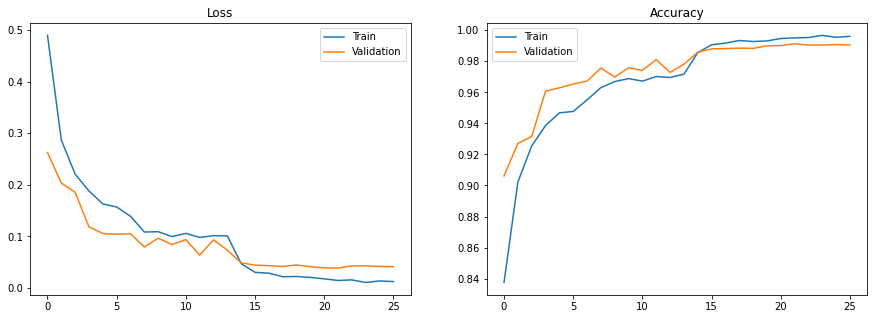

In [30]:
# 4.3.5 EVALUATE THE MODEL

# Model evaluation 
loss_nasnet, accuracy_nasnet = history_nasnet[['val_loss','val_accuracy']].values[-1]
print("Nasnet accuracy: ", accuracy_nasnet,
      "\nNasnet loss: ", loss_nasnet)

# results visualisation
history_plot(history_nasnet)

(6063, 10)


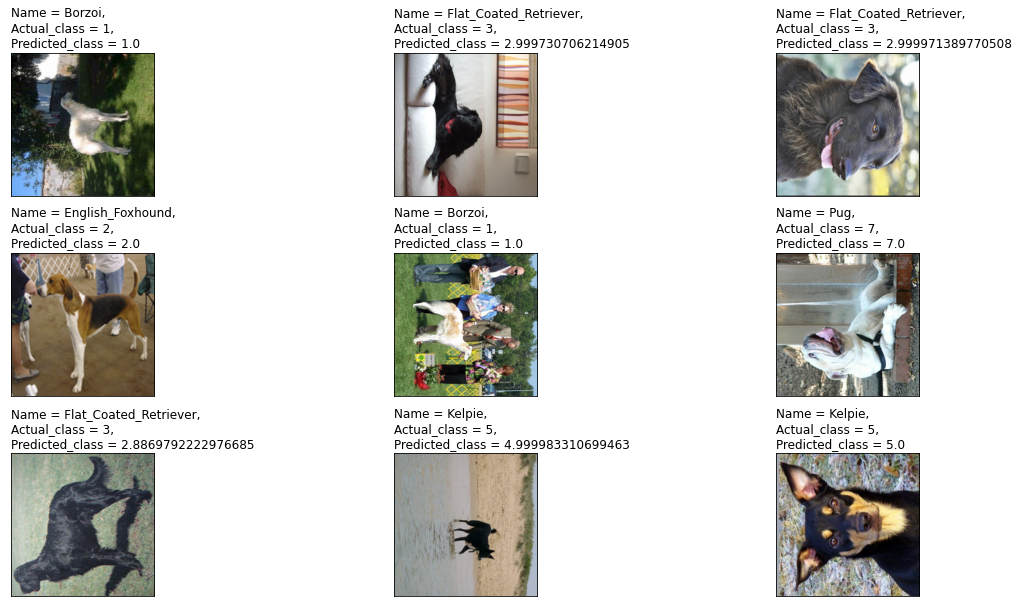

In [31]:
# 4.3.6 MAKE PREDICTION

# Prediction 
pred_nasnet = model_nasnet.predict(X_test)
print(pred_nasnet.shape)

# Prediction visualisation
predicted_images(pred_nasnet)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       755
           1       0.98      1.00      0.99       522
           2       0.99      0.99      0.99       565
           3       0.98      0.97      0.98       517
           4       1.00      0.99      1.00       705
           5       0.97      0.98      0.97       572
           6       1.00      0.99      1.00       562
           7       1.00      0.99      0.99       711
           8       0.99      1.00      0.99       573
           9       1.00      1.00      1.00       581

    accuracy                           0.99      6063
   macro avg       0.99      0.99      0.99      6063
weighted avg       0.99      0.99      0.99      6063



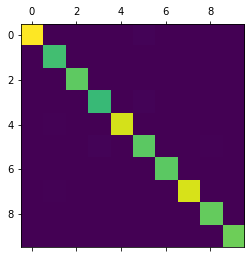

In [32]:
# 4.3.7 PRINT THE CONFUSION MATRIX

plt.matshow(confusion_matrix(Y_test, pred_nasnet.argmax(axis=1)))
print(classification_report(Y_test, pred_nasnet.argmax(axis=1)))

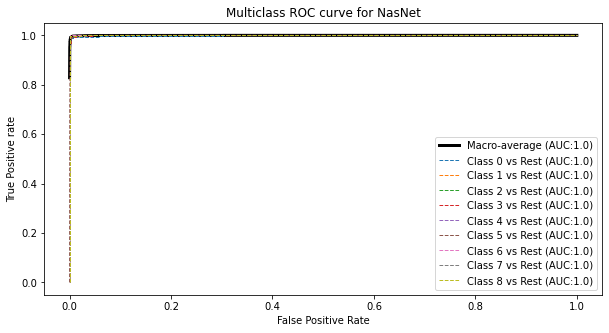

In [33]:
# 4.3.8 PLOT THE ROC CURVE

auc_nasnet = ROC_plot(y_test=Y_test, y_pred=pred_nasnet, model_name='NasNet')

## 5. Final results

In [5]:
Model = ['AlexNet', 
         'VGG16', 
         'ResNet', 
         'ResNet Transfer',
         'DenseNet', 
         'NasNet']
Learning = ['Learning from scratch',
            'Learning from scratch', 
            'Learning from scratch', 
            'Transfer learning', 
            'Transfer learning', 
            'Transfer learning']
Times = [str(alexnet_time), 
         str(vgg16_time), 
         str(resnet_time), 
         str(resnet_transfer_time), 
         str(densenet_time), 
         str(nasnet_time)]
Accuracy = [round(accuracy_alexnet, 4), 
            round(accuracy_vgg16, 4), 
            round(accuracy_resnet, 4), 
            round(accuracy_resnet_transfer, 4), 
            round(accuracy_densenet, 4), 
            round(accuracy_nasnet, 4)]
Losses = [round(loss_alexnet, 4), 
          round(loss_vgg16, 4),
          round(loss_resnet, 4), 
          round(loss_resnet_transfer, 4),
          round(loss_densenet, 4), 
          round(loss_nasnet, 4)]
AUC = [round(auc_alexnet, 2), 
       round(auc_vgg16, 2), 
       round(auc_resnet, 2), 
       round(auc_resnet_transfer, 2),
       round(auc_densenet, 2), 
       round(auc_nasnet, 2)]


df = pd.DataFrame(data = {"Model name": Model,
                          "Learning type": Learning,
                          "Time": Times,
                          "Validation Loss": Losses,
                          "Validation Accuracy": Accuracy,
                          "AUC score": AUC})
df.Time = df.Time.str[:7]
df.head(6)

Model name          Learning type     Time  Validation Loss  \
0          AlexNet  Learning from scratch  7:41:26           0.2593   
1            VGG16  Learning from scratch  14:52:0           2.2950   
2           ResNet  Learning from scratch  8:51:11           2.3026   
3  ResNet Transfer      Transfer learning  9:45:49           2.2074   
4         DenseNet      Transfer learning  7:14:17           0.0309   
5           NasNet      Transfer learning  7:01:10           0.0413   

   Validation Accuracy  AUC score  
0               0.9156       1.00  
1               0.1245       0.50  
2               0.1245       0.50  
3               0.2144       0.65  
4               0.9901       1.00  
5               0.9904       1.00

As we can see from the summary table, AlexNet, DenseNet and NasNet models were all effective in learning the features of the dataset to such extent, that it is hard to make a decision regarding a champion model. On one hand we have transfer learning models that were able to reach a high level of accuracy in a very short time. On the other, AlexNet was able to reach the same result without using any external help. The model choice will depend on the task at hand and desired result.

As for VGGNet and ResNet, their poor performace can be explained by the fact that these models have a are very complex and deep architecture. Their effectiveness depends on large amounts of data. Unfortunately, in our case we have 20208 images that are divided into 10 categories. This means that on average there are around 2000 images per breed from which the 19 and 152 layer deep models are simply not able to learn the features. 

![title](images/network_depth.png)

This is also confirmed by the ResNet transfer model, which was able to achieve a better result than simple ResNet due to previously learned features. However, its performance remains weak. It is expected that on the full dataset these models will have a better performance on the full data, while AlexNet with its 8 layer architecture will lose accuracy.